In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

# 1. LOAD AND MERGE DATA (As per Proposal)
df_train = pd.read_csv('room_energy_20rooms_10days.csv')
df_with_co2 = pd.read_csv('building_energy_data_with_co2.csv')
df_unseen = pd.read_csv('building_energy_data (1).csv')

# Combine the 200 rows and 100 rows into 300 rows for better training
common_cols = ['Room_Type', 'AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy', 'Power_kWh', 'CO2_kg']
df_merged = pd.concat([df_train[common_cols], df_with_co2[common_cols]], ignore_index=True)

# 2. PREPROCESSING
features = ['Room_Type', 'AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy']
target_power = 'Power_kWh'
target_co2 = 'CO2_kg'

# One-Hot Encoding for Room_Type
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(df_merged[['Room_Type']])

def get_features(df):
    encoded_rooms = encoder.transform(df[['Room_Type']])
    room_cols = encoder.get_feature_names_out(['Room_Type'])
    X_numeric = df[['AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy']].values
    return np.hstack([encoded_rooms, X_numeric])

X = get_features(df_merged)
y_p = df_merged[target_power]
y_c = df_merged[target_co2]

# 3. MODELING (Random Forest Regressor)
model_power = RandomForestRegressor(n_estimators=100, random_state=42)
model_co2 = RandomForestRegressor(n_estimators=100, random_state=42)

model_power.fit(X, y_p)
model_co2.fit(X, y_c)

# 4. GRADIO INTERFACE FUNCTION
def predict_sustainability(room_type, ac, computers, gpus, hours, occupancy):
    # Prepare input for prediction
    input_df = pd.DataFrame([[room_type, ac, computers, gpus, hours, occupancy]],
                            columns=features)
    X_input = get_features(input_df)

    # Predict
    p_pred = model_power.predict(X_input)[0]
    c_pred = model_co2.predict(X_input)[0]

    return f"{p_pred:.2f} kWh", f"{c_pred:.2f} kg"

# 5. LAUNCH GRADIO UI
room_options = list(df_merged['Room_Type'].unique())

iface = gr.Interface(
    fn=predict_sustainability,
    inputs=[
        gr.Dropdown(choices=room_options, label="Room Type"),
        gr.Slider(0, 5, step=1, label="AC Count"),
        gr.Slider(0, 50, step=1, label="Computer Count"),
        gr.Slider(0, 10, step=1, label="GPU Count"),
        gr.Slider(1, 24, step=1, label="Hours Used Daily"),
        gr.Slider(0, 100, step=1, label="Occupancy")
    ],
    outputs=[
        gr.Textbox(label="Predicted Energy Consumption"),
        gr.Textbox(label="Predicted CO2 Emissions")
    ],
    title="Sustainability AI: Building Energy Predictor",
    description="Input room specs to see real-time impact on Energy and Carbon Footprint."
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://54a0e935775eb1d240.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
# Cell 2: Imports and Data Loading
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import joblib
import gradio as gr

In [5]:
# Load the three datasets
df_train_200 = pd.read_csv('room_energy_20rooms_10days.csv')
df_val_100 = pd.read_csv('building_energy_data_with_co2.csv')
df_unseen = pd.read_csv('building_energy_data (1).csv')

print("Datasets Loaded Successfully!")

Datasets Loaded Successfully!


In [9]:
# Merge the 200 and 100 row files
common_cols = ['Room_Type', 'AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy', 'Power_kWh', 'CO2_kg']
df_merged = pd.concat([df_train_200[common_cols], df_val_100[common_cols]], ignore_index=True)

In [10]:
# Save the merged file
df_merged.to_csv('merged_training_data.csv', index=False)
print("Merged dataset saved as 'merged_training_data.csv'")
df_merged.head()

Merged dataset saved as 'merged_training_data.csv'


,Room_Type,AC_Count,Computer_Count,GPU_Count,Hours_Used,Occupancy,Power_kWh,CO2_kg
0,Office,2,15,2,8,21,40.8,25.30
1,Office,1,19,2,6,24,24.0,14.88
2,Office,1,4,2,9,21,22.5,13.95
3,Office,2,24,3,9,6,56.7,35.15
4,Office,2,21,0,7,26,35.7,22.13


In [11]:
# Cell 3: Download and Read back
from google.colab import files
files.download('merged_training_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# Read the newly created merged file
df_master = pd.read_csv('merged_training_data.csv')
print(f"Master training dataset loaded. Total rows: {len(df_master)}")

Master training dataset loaded. Total rows: 300


In [13]:
# Cell 4: One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(df_master[['Room_Type']])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [14]:
def preprocess_df(df, encoder_obj):
    # Encode Room_Type
    encoded_rooms = encoder_obj.transform(df[['Room_Type']])
    room_cols = encoder_obj.get_feature_names_out(['Room_Type'])

    # Extract numerical features
    num_data = df[['AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy']].values

    # Combine
    X = np.hstack([encoded_rooms, num_data])
    return X

X_train = preprocess_df(df_master, encoder)
y_power = df_master['Power_kWh']
y_co2 = df_master['CO2_kg']

In [15]:
# Cell 5: Training
model_power = RandomForestRegressor(n_estimators=100, random_state=42)
model_co2 = RandomForestRegressor(n_estimators=100, random_state=42)

model_power.fit(X_train, y_power)
model_co2.fit(X_train, y_co2)

print("Models trained on 300 rows successfully.")

Models trained on 300 rows successfully.


In [16]:
# Cell 5.1: Performance Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the training data to see how well the model learned
y_p_pred = model_power.predict(X_train)
y_c_pred = model_co2.predict(X_train)

# Calculate Metrics
rmse_p = np.sqrt(mean_squared_error(y_power, y_p_pred))
r2_p = r2_score(y_power, y_p_pred)

rmse_c = np.sqrt(mean_squared_error(y_co2, y_c_pred))
r2_c = r2_score(y_co2, y_c_pred)

print("--- Power Consumption Model ---")
print(f"RMSE (Error): {rmse_p:.4f} kWh")
print(f"R-squared (Accuracy): {r2_p:.4f}")

print("\n--- CO2 Emission Model ---")
print(f"RMSE (Error): {rmse_c:.4f} kg")
print(f"R-squared (Accuracy): {r2_c:.4f}")

--- Power Consumption Model ---
RMSE (Error): 1.2546 kWh
R-squared (Accuracy): 0.9905

--- CO2 Emission Model ---
RMSE (Error): 0.7740 kg
R-squared (Accuracy): 0.9905


In [17]:
# Cell 5.1: 5-Fold Cross-Validation
from sklearn.model_selection import cross_validate

# Define the 5-Fold Cross-Validation strategy
# We evaluate both Power and CO2 models
metrics = ['neg_root_mean_squared_error', 'r2']

# Evaluate Power Model
cv_power = cross_validate(model_power, X_train, y_power, cv=5, scoring=metrics)
# Evaluate CO2 Model
cv_co2 = cross_validate(model_co2, X_train, y_co2, cv=5, scoring=metrics)

# Format the results (convert negative RMSE to positive)
print("--- 5-Fold Cross-Validation Results ---")
print(f"Power Model Avg RMSE: {-cv_power['test_neg_root_mean_squared_error'].mean():.4f} kWh")
print(f"Power Model Avg R2 Score: {cv_power['test_r2'].mean():.4f}")

print(f"\nCO2 Model Avg RMSE: {-cv_co2['test_neg_root_mean_squared_error'].mean():.4f} kg")
print(f"CO2 Model Avg R2 Score: {cv_co2['test_r2'].mean():.4f}")

--- 5-Fold Cross-Validation Results ---
Power Model Avg RMSE: 3.6860 kWh
Power Model Avg R2 Score: 0.9153

CO2 Model Avg RMSE: 2.2831 kg
CO2 Model Avg R2 Score: 0.9156


In [18]:
# Cell 6: Final Prediction on Unseen Data
# Preprocess the unseen data using the SAME encoder from Step 4
X_unseen = preprocess_df(df_unseen, encoder)

# Apply the trained models to generate results for Phase 4
df_unseen['Predicted_Power_kWh'] = model_power.predict(X_unseen)
df_unseen['Predicted_CO2_kg'] = model_co2.predict(X_unseen)

# Save the final results to a CSV for your Phase 4 Report submission
df_unseen.to_csv('final_unseen_results.csv', index=False)
print("Final predictions for 'building_energy_data (1).csv' saved to 'final_unseen_results.csv'")

# Display the first few rows of your predictions
df_unseen[['Room_ID', 'Room_Type', 'Predicted_Power_kWh', 'Predicted_CO2_kg']].head()

Final predictions for 'building_energy_data (1).csv' saved to 'final_unseen_results.csv'


,Room_ID,Room_Type,Predicted_Power_kWh,Predicted_CO2_kg
0,101,Research Lab,16.120,10.0257
1,102,Washroom,21.735,13.4664
2,103,Lab,33.865,21.0391
3,104,Office,27.390,17.0063
4,105,Classroom,28.252,17.4414


/tmp/ipython-input-3994093046.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='magma')


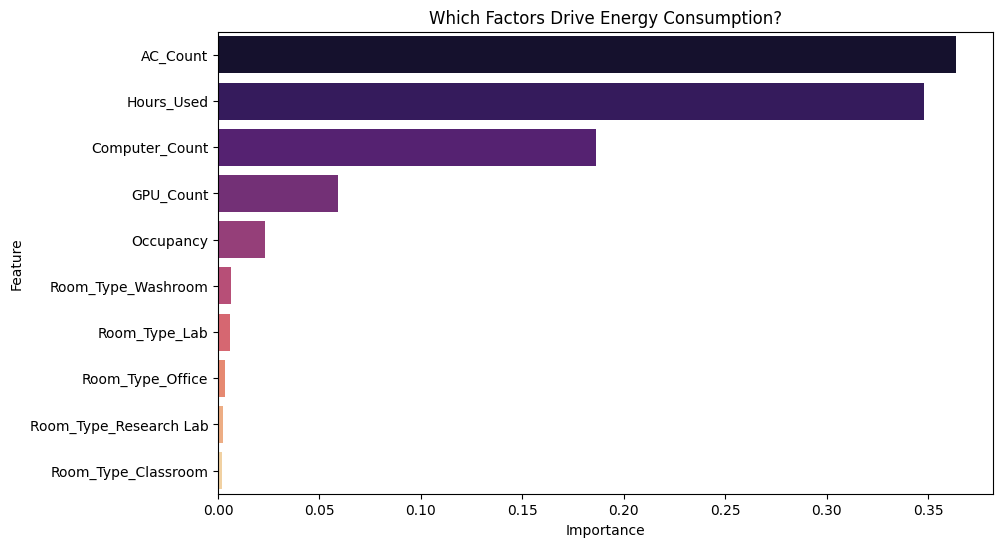

In [21]:
# Cell 8: Feature Importance (For your Report Analysis)
import matplotlib.pyplot as plt
import seaborn as sns

# Get the names of the features after One-Hot Encoding
room_cols = list(encoder.get_feature_names_out(['Room_Type']))
all_features = room_cols + ['AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy']

# Get importance values from the trained Power model
importances = model_power.feature_importances_

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='magma')
plt.title('Which Factors Drive Energy Consumption?')
plt.show()

In [24]:
# Cell 7: Launching the Gradio Interface
def live_prediction(room, ac, comp, gpu, hours, occ):
    # 1. Create a single-row dataframe from Gradio inputs
    input_data = pd.DataFrame([[room, ac, comp, gpu, hours, occ]],
                              columns=['Room_Type', 'AC_Count', 'Computer_Count', 'GPU_Count', 'Hours_Used', 'Occupancy'])

    # 2. Preprocess the input using the same logic as training
    X_input = preprocess_df(input_data, encoder)

    # 3. Get predictions from both models
    p_result = model_power.predict(X_input)[0]
    c_result = model_co2.predict(X_input)[0]

    return f"{p_result:.2f} kWh", f"{c_result:.2f} kg"

# Get unique room types for the dropdown menu
room_list = list(df_master['Room_Type'].unique())

# Setup the UI
iface = gr.Interface(
    fn=live_prediction,
    inputs=[
        gr.Dropdown(choices=room_list, label="Select Room Type"),
        gr.Slider(0, 5, step=1, label="Air Conditioners (AC)"),
        gr.Slider(0, 50, step=1, label="Number of Computers"),
        gr.Slider(0, 10, step=1, label="Number of GPUs"),
        gr.Slider(1, 24, step=1, label="Usage Duration (Hours/Day)"),
        gr.Slider(0, 100, step=1, label="Average Occupancy")
    ],
    outputs=[
        gr.Textbox(label="Predicted Power Consumption"),
        gr.Textbox(label="Predicted Carbon Footprint (CO2)")
    ],
    title="Sustainability AI Dashboard",
    description="Adjust the sliders to simulate room usage and see the impact on energy and CO2 emissions."
)

# Launch with share=True to get a public link for your report
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b135b05decc9eeb23f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
